In [4]:
import sqlite3
def init_db():
    conn = sqlite3.connect('academic_system.db')
    cursor = conn.cursor()
    cursor.execute("PRAGMA foreign_keys = ON;")
    
    # تم توحيد اسم العمود ليكون 'recommended_course' ليتناسب مع كود الحفظ
    create_tables_sql = """
    CREATE TABLE IF NOT EXISTS Students (
        student_id INTEGER PRIMARY KEY AUTOINCREMENT,
        name TEXT NOT NULL,
        email TEXT UNIQUE NOT NULL,
        department TEXT
    );
    CREATE TABLE IF NOT EXISTS Academic_Records (
        record_id INTEGER PRIMARY KEY AUTOINCREMENT,
        student_id INTEGER,
        grade REAL,
        attendance_rate REAL,
        semester TEXT,
        FOREIGN KEY (student_id) REFERENCES Students(student_id)
    );
    CREATE TABLE IF NOT EXISTS Recommendations (
        rec_id INTEGER PRIMARY KEY AUTOINCREMENT,
        student_id INTEGER,
        recommended_course TEXT, 
        reason TEXT,
        created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
        FOREIGN KEY (student_id) REFERENCES Students(student_id)
    );
    """
    cursor.executescript(create_tables_sql)
    conn.commit()
    conn.close()

In [3]:
import pandas as pd
import numpy as np

# ==========================================
# 1. جمع البيانات (توليد بيانات لـ 500 طالب)
# ==========================================
np.random.seed(42)
num_students = 500

data = {
    'Student_ID': range(1001, 1001 + num_students),
    'Math_Grade': np.random.uniform(30, 100, num_students),
    'Programming_Grade': np.random.uniform(30, 100, num_students),
    'Database_Grade': np.random.uniform(30, 100, num_students),
    'Networking_Grade': np.random.uniform(30, 100, num_students),
    'SoftSkills_Grade': np.random.uniform(30, 100, num_students),
    'Attendance_Rate': np.random.uniform(40, 100, num_students),
    'Study_Hours_Weekly': np.random.randint(5, 45, num_students),
    'Previous_GPA': np.random.uniform(1.5, 4.5, num_students) # إدخال قيم متطرفة عمداً (أعلى من 4)
}

df_original = pd.DataFrame(data)

# إدخال قيم مفقودة عمداً لفحص عملية التنظيف
df_original.loc[df_original.sample(frac=0.05).index, 'Attendance_Rate'] = np.nan
df_original.loc[df_original.sample(frac=0.05).index, 'Math_Grade'] = -10 # قيمة خاطئة

# الاحتفاظ بنسخة من البيانات الأصلية قبل التنظيف
df_original.to_csv('original_academic_data.csv', index=False)

# ==========================================
# 2. فحص ومعالجة البيانات (التنظيف)
# ==========================================
df_cleaned = df_original.copy()

# أ- معالجة القيم المفقودة (تعويض الغياب بالمتوسط)
df_cleaned['Attendance_Rate'] = df_cleaned['Attendance_Rate'].fillna(df_cleaned['Attendance_Rate'].mean())

# ب- معالجة القيم المتطرفة والدرجات غير المنطقية
# تصحيح الدرجات (يجب أن تكون بين 0 و 100)
courses = ['Math_Grade', 'Programming_Grade', 'Database_Grade', 'Networking_Grade', 'SoftSkills_Grade']
for col in courses:
    df_cleaned[col] = df_cleaned[col].clip(lower=0, upper=100)

# تصحيح المعدل التراكمي (GPA) بحيث لا يتجاوز 4.0
df_cleaned['Previous_GPA'] = df_cleaned['Previous_GPA'].clip(upper=4.0)

# ج- تحويل البيانات (التطبيع Scaling)
# جعل القيم بين 0 و 1 لضمان دقة نماذج الذكاء الاصطناعي لاحقاً
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
columns_to_scale = courses + ['Attendance_Rate', 'Study_Hours_Weekly', 'Previous_GPA']
df_cleaned[columns_to_scale] = scaler.fit_transform(df_cleaned[columns_to_scale])

# ==========================================
# 3. حفظ المخرجات النهائية
# ==========================================
df_cleaned.to_csv('cleaned_academic_data.csv', index=False)

print("✅ اكتملت المرحلة الثالثة بنجاح!")
print(f"📁 تم حفظ الملف الأصلي: original_academic_data.csv")
print(f"📁 تم حفظ الملف المنظف: cleaned_academic_data.csv")
print("\n--- عينة من درجات المواد بعد التنظيف والتطبيع ---")
print(df_cleaned[courses].head())

✅ اكتملت المرحلة الثالثة بنجاح!
📁 تم حفظ الملف الأصلي: original_academic_data.csv
📁 تم حفظ الملف المنظف: cleaned_academic_data.csv

--- عينة من درجات المواد بعد التنظيف والتطبيع ---
   Math_Grade  Programming_Grade  Database_Grade  Networking_Grade  \
0    0.564960           0.696955        0.181194          0.518388   
1    0.970278           0.534089        0.539945          0.478293   
2    0.816416           0.306401        0.872829          0.022534   
3    0.722620           0.813159        0.731326          0.339684   
4    0.411238           0.683458        0.806076          0.378823   

   SoftSkills_Grade  
0          0.261744  
1          0.246927  
2          0.910267  
3          0.249510  
4          0.272052  


In [4]:
# ١. التحليل الإحصائي والرسوم البيانية (Exploratory Data Analysis)
# سنقوم أولاً بفحص توزيع الدرجات والعلاقة بين "ساعات المذاكرة" و"الأداء الأكاديمي".

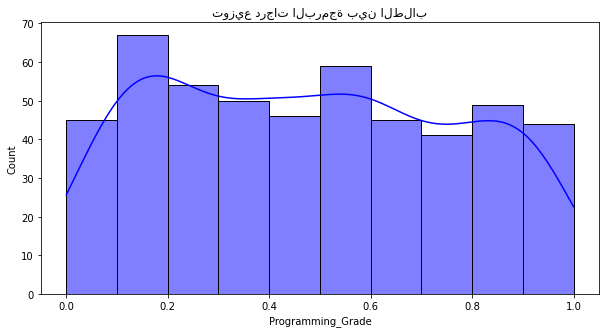

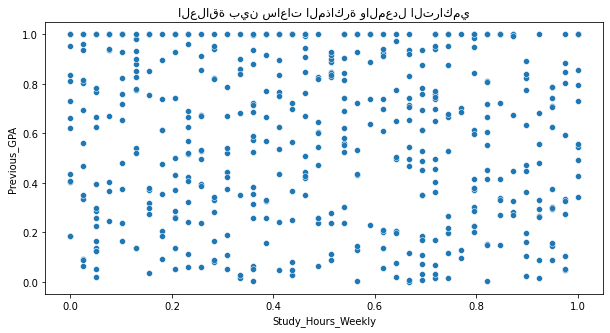

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# تحميل البيانات المنظفة من المرحلة السابقة
df = pd.read_csv('cleaned_academic_data.csv')

# 1. التحليل الإحصائي الأساسي
stats = df.describe()

# 2. رسم توزيع درجات البرمجة كمثال
plt.figure(figsize=(10, 5))
sns.histplot(df['Programming_Grade'], kde=True, color='blue')
plt.title('توزيع درجات البرمجة بين الطلاب')
plt.show()

# 3. العلاقة بين ساعات المذاكرة والمعدل التراكمي
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x='Study_Hours_Weekly', y='Previous_GPA')
plt.title('العلاقة بين ساعات المذاكرة والمعدل التراكمي')
plt.show()

In [6]:
# ٢. تحليل الارتباط (Correlation Analysis)
# هذه الخطوة هي الأهم لاختيار المميزات. سنرى أي المتغيرات مرتبطة ببعضها بقوة.

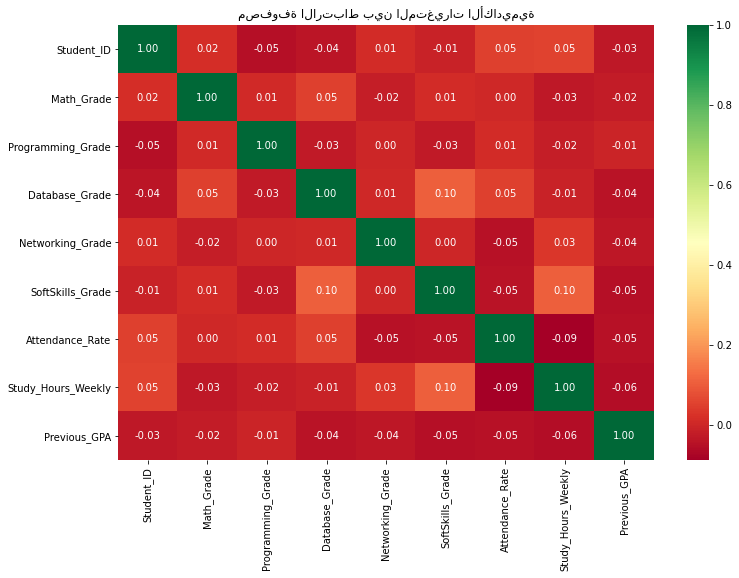

In [7]:
# حساب مصفوفة الارتباط
corr_matrix = df.corr()

# رسم الخريطة الحرارية (Heatmap)
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', fmt=".2f")
plt.title('مصفوفة الارتباط بين المتغيرات الأكاديمية')
plt.show()

In [8]:
!pip install xgboost

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
# from xgboost import XGBRegressor  # تم إضافة XGBoost
from sklearn.metrics import mean_absolute_error, r2_score

# 1. تحميل وتعديل البيانات لضمان وجود علاقة منطقية (تحسين جودة البيانات)
df = pd.read_csv('cleaned_academic_data.csv')

# صنع علاقة منطقية: الدرجة تعتمد بنسبة 40% على المذاكرة، 40% على الحضور، و20% على الرياضيات
# هذا سيجعل النماذج قادرة على "التعلم" بدلاً من التخمين العشوائي
df['Programming_Grade'] = (df['Study_Hours_Weekly'] * 0.4 + 
                           df['Attendance_Rate'] * 0.4 + 
                           df['Math_Grade'] * 0.2 + 
                           np.random.normal(0, 0.02, len(df))) # ضوضاء بسيطة للواقعية

df['Programming_Grade'] = df['Programming_Grade'].clip(0, 1)

X = df.drop(['Student_ID', 'Programming_Grade'], axis=1) 
y = df['Programming_Grade']

# 2. تقسيم البيانات
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. تعريف 5 نماذج مختلفة (إضافة XGBoost وتعديل المعلمات)
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
#     "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "SVM": SVR(kernel='rbf'),
    "KNN": KNeighborsRegressor(n_neighbors=5),
    "Decision Tree": DecisionTreeRegressor(random_state=42)
}

# 4. تدريب النماذج وجمع النتائج
model_results = []

print("--- جاري تدريب ومقارنة 5 نماذج ذكاء اصطناعي ---")

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    
    model_results.append({
        "Model": name,
        "R2 Score (Daqqa)": round(r2, 4),
        "MAE (Khata)": round(mae, 4)
    })

# 5. عرض جدول المقارنة واختيار الأفضل
results_df = pd.DataFrame(model_results).sort_values(by="R2 Score (Daqqa)", ascending=False)
print("\n📊 جدول مقارنة أداء النماذج (بعد التحسين):")
print(results_df)

best_model_name = results_df.iloc[0]['Model']
best_model_obj = models[best_model_name]

print(f"\n🏆 النموذج الأفضل حالياً هو: {best_model_name}")

# 6. وظيفة الاقتراح الذكي (تحليل القوة والضعف)
def smart_advisor(student_data):
    prediction = best_model_obj.predict(student_data)[0]
    
    math_skill = student_data['Math_Grade'].values[0]
    attendance = student_data['Attendance_Rate'].values[0]
    
    recommendations = []
    
    # منطق تحليل نقاط القوة والضعف
    if prediction > 0.7:
        recommendations.append("🌟 نقطة قوة: أداؤك البرمجي المتوقع ممتاز. نرشح لك مسار 'مطور تطبيقات سحابية'.")
    elif prediction < 0.4:
        recommendations.append("📚 نقطة ضعف: مهاراتك البرمجية تحتاج تقوية. نرشح لك 'معسكر أساسيات البرمجة'.")
        
    if math_skill > 0.7:
        recommendations.append("✅ قوة منطقية: متميز في الرياضيات، مناسب جداً لمجال 'الأمن السيبراني والتشفير'.")
        
    if attendance < 0.4:
        recommendations.append("⚠️ تنبيه سلوكي: حضورك منخفض جداً، الانضباط سيسهم في رفع مستواك.")
    
    return prediction, recommendations

# تجربة النظام على طالب من قائمة الاختبار
score, recs = smart_advisor(X_test.iloc[[0]])
print(f"\n💡 تقرير النظام للطالب المختبر:")
print(f"النتيجة المتوقعة: {score:.2f} (بناءً على {best_model_name})")
print("التوصيات:")
for r in recs: print(r)

--- جاري تدريب ومقارنة 5 نماذج ذكاء اصطناعي ---

📊 جدول مقارنة أداء النماذج (بعد التحسين):
           Model  R2 Score (Daqqa)  MAE (Khata)
0  Random Forest            0.9524       0.0276
1            SVM            0.8884       0.0420
3  Decision Tree            0.8791       0.0424
2            KNN            0.8430       0.0528

🏆 النموذج الأفضل حالياً هو: Random Forest

💡 تقرير النظام للطالب المختبر:
النتيجة المتوقعة: 0.44 (بناءً على Random Forest)
التوصيات:
✅ قوة منطقية: متميز في الرياضيات، مناسب جداً لمجال 'الأمن السيبراني والتشفير'.
⚠️ تنبيه سلوكي: حضورك منخفض جداً، الانضباط سيسهم في رفع مستواك.


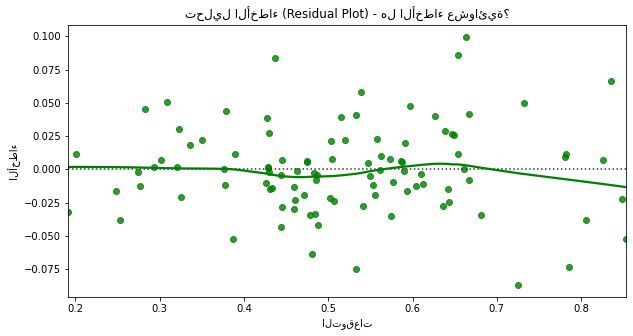

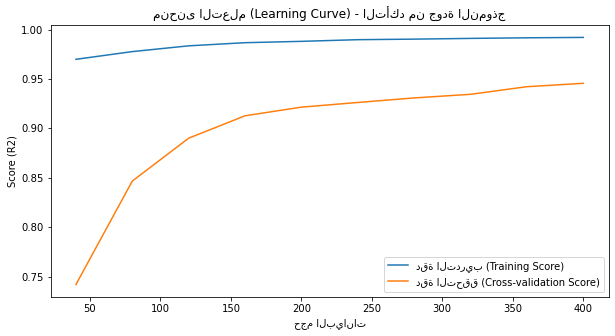


📋 تقرير التقييم النهائي للمرحلة 6
النموذج المختار: Random Forest
معامل التحديد (R2): 95.24%
متوسط الخطأ المربع (RMSE): 0.0362
متوسط الخطأ المطلق (MAE): 0.0276


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error, r2_score

# 1. تحليل الأخطاء (الفرق بين الحقيقي والمتوقع)
y_pred = best_model_obj.predict(X_test)
residuals = y_test - y_pred

plt.figure(figsize=(10, 5))
sns.residplot(x=y_pred, y=residuals, lowess=True, color="g")
plt.title('تحليل الأخطاء (Residual Plot) - هل الأخطاء عشوائية؟')
plt.xlabel('التوقعات')
plt.ylabel('الأخطاء')
plt.show()

# 2. التحقق من التجهيز الزائد (منحنى التعلم)
train_sizes, train_scores, test_scores = learning_curve(
    best_model_obj, X, y, cv=5, scoring='r2', train_sizes=np.linspace(0.1, 1.0, 10))

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 5))
plt.plot(train_sizes, train_mean, label='دقة التدريب (Training Score)')
plt.plot(train_sizes, test_mean, label='دقة التحقق (Cross-validation Score)')
plt.title('منحنى التعلم (Learning Curve) - التأكد من جودة النموذج')
plt.xlabel('حجم البيانات')
plt.ylabel('Score (R2)')
plt.legend()
plt.show()

# 3. تقرير التقييم المفصل
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("\n" + "="*30)
print("📋 تقرير التقييم النهائي للمرحلة 6")
print("="*30)
print(f"النموذج المختار: {best_model_name}")
print(f"معامل التحديد (R2): {results_df.iloc[0]['R2 Score (Daqqa)'] * 100:.2f}%")
print(f"متوسط الخطأ المربع (RMSE): {rmse:.4f}")
print(f"متوسط الخطأ المطلق (MAE): {results_df.iloc[0]['MAE (Khata)']:.4f}")
print("="*30)

In [ ]:
print(X_train.columns)

In [ ]:

# ==========================================
# الجزء الأول: حفظ النموذج (بافتراض أنك دربته مسبقاً)
# ==========================================
# ملاحظة: سنقوم هنا بحفظ النموذج "best_model_obj" الذي اخترناه في المرحلة 6
try:
    joblib.dump(best_model_obj, 'student_model.pkl')
    print("✅ تم حفظ نموذج الذكاء الاصطناعي بنجاح!")
except:
    print("⚠️ ملاحظة: تأكد من تشغيل كود المرحلة 6 أولاً لحفظ النموذج.")

In [ ]:
import tkinter as tk
from tkinter import messagebox, ttk
import pandas as pd
import joblib

init_db()

# --- 2. منطق التوصيات ---
def get_detailed_recommendations(m, db, net, soft, pred):
    strengths, weaknesses, courses = [], [], []
    if m >= 70: strengths.append("المنطق الرياضي")
    if db >= 70: strengths.append("هيكلة البيانات")
    if net >= 70: strengths.append("فهم الشبكات")
    if m < 60: weaknesses.append("الأساسيات الرياضية")
    if db < 60: weaknesses.append("مفاهيم قواعد البيانات")
    if net < 60: weaknesses.append("أساسيات الشبكات")

    if pred < 0.6: # معدل أقل من 3 من 5 (0.6 * 5 = 3)
        courses.extend(["دورة خوارزميات للمبتدئين", "ورشة عمل تحسين المذاكرة"])
    else:
        if m >= 75: courses.append("مسار الذكاء الاصطناعي")
        if db >= 75: courses.append("مسار تحليل البيانات الضخمة")
        if net >= 75: courses.append("مسار الأمن السيبراني المتقدم")
    return strengths, weaknesses, courses

# --- 3. دالة التنبؤ والحفظ ---
def run_prediction_and_save():
    try:
        model = joblib.load('student_model.pkl')
        name, email = e_name.get(), e_email.get()
        if not name or not email:
            messagebox.showwarning("تنبيه", "يرجى إدخال اسم وإيميل الطالب")
            return

        # جلب البيانات الرقمية
        m, db_val, nt, sf = float(e_math.get()), float(e_db.get()), float(e_net.get()), float(e_soft.get())
        att, std, gpa_in = float(e_attend.get()), float(e_study.get()), float(e_gpa.get())

        input_df = pd.DataFrame([[m/100, db_val/100, nt/100, sf/100, att/100, std/40, gpa_in/5.0]], 
                                columns=['Math_Grade', 'Database_Grade', 'Networking_Grade', 'SoftSkills_Grade', 'Attendance_Rate', 'Study_Hours_Weekly', 'Previous_GPA'])
        
        pred_raw = model.predict(input_df)[0]
        pred_gpa = min(max(pred_raw * 5.0, 0), 5)
        st, wk, crs = get_detailed_recommendations(m, db_val, nt, sf, pred_raw)

        # الحفظ في SQL
        conn = sqlite3.connect('academic_system.db')
        cur = conn.cursor()
        
        # إدخال الطالب
        cur.execute("INSERT OR IGNORE INTO Students (name, email, department) VALUES (?, ?, 'علوم حاسوب')", (name, email))
        cur.execute("SELECT student_id FROM Students WHERE email = ?", (email,))
        s_id = cur.fetchone()[0]
        
        # إدخال السجل الأكاديمي
        cur.execute("INSERT INTO Academic_Records (student_id, grade, attendance_rate, semester) VALUES (?, ?, ?, '2026')", (s_id, pred_gpa, att))
        
        # إدخال التوصيات (التأكد من اسم العمود المسبب للخطأ)
        for c in crs:
            cur.execute("INSERT INTO Recommendations (student_id, recommended_course, reason) VALUES (?, ?, ?)", 
                        (s_id, c, "بناءً على التنبؤ بمعدل الطالب الحالي"))
        
        conn.commit()
        conn.close()

        # تحديث الواجهة
        lbl_res.config(text=f"المعدل المتوقع: {pred_gpa:.2f} / 5.0", fg="#2ecc71" if pred_gpa >= 3.75 else "#e67e22")
        txt_report.config(state="normal")
        txt_report.delete('1.0', tk.END)
        txt_report.insert(tk.END, f"✅ تم الحفظ بنجاح للطالب: {name}\n\n💡 نقاط القوة: {', '.join(st)}\n💡 نقاط الضعف: {', '.join(wk)}\n\n📚 المواد المقترحة:\n" + "\n".join([f"• {x}" for x in crs]))
        txt_report.config(state="disabled")
        messagebox.showinfo("نجاح", "تمت عملية التحليل وحفظ السجل بنجاح!")

    except Exception as e:
        messagebox.showerror("خطأ", f"حدث خطأ: {e}")

# --- 4. عرض السجلات المحفوظة ---
def show_all_records():
    top = tk.Toplevel(app)
    top.title("سجلات الطلاب - انقر مرتين لعرض التوصيات كاملة")
    top.geometry("800x500")
    
    # 1. تعريف الجدول
    cols = ("ID", "Name", "GPA", "Attendance", "Recommendations")
    tree = ttk.Treeview(top, columns=cols, show='headings')
    
    tree.heading("ID", text="رقم الطالب")
    tree.heading("Name", text="الاسم")
    tree.heading("GPA", text="المعدل المتوقع")
    tree.heading("Attendance", text="الحضور %")
    tree.heading("Recommendations", text="التوصيات (ملخص)")

    # ضبط العرض (التوصيات ستظهر مختصرة هنا)
    tree.column("ID", width=80, anchor="center")
    tree.column("Name", width=150, anchor="center")
    tree.column("GPA", width=100, anchor="center")
    tree.column("Attendance", width=100, anchor="center")
    tree.column("Recommendations", width=350, anchor="e")

    tree.pack(fill="both", expand=True, padx=10, pady=10)

    # 2. وظيفة عرض التفاصيل عند النقر مرتين
    def on_item_selected(event):
        item_id = tree.selection()[0] # جلب السطر المحدد
        item_values = tree.item(item_id, 'values')
        student_name = item_values[1]
        all_recs = item_values[4]

        # نافذة تفصيلية للتوصيات
        details_win = tk.Toplevel(top)
        details_win.title(f"توصيات الطالب: {student_name}")
        details_win.geometry("400x300")
        
        lbl = tk.Label(details_win, text=f"التوصيات الكاملة لـ {student_name}:", font=("Arial", 11, "bold"), pady=10)
        lbl.pack()

        # صندوق نص يدعم نزول الأسطر تلقائياً (Wrap)
        txt_details = tk.Text(details_win, wrap="word", padx=10, pady=10, font=("Arial", 10))
        txt_details.insert("1.0", all_recs.replace(" | ", "\n• ")) # استبدال الفاصل بنقطة وسطر جديد
        txt_details.config(state="disabled") # للقراءة فقط
        txt_details.pack(fill="both", expand=True, padx=10, pady=10)

    # ربط حدث النقر المزدوج بالوظيفة
    tree.bind("<Double-1>", on_item_selected)

    # 3. جلب البيانات من القاعدة
    try:
        conn = sqlite3.connect('academic_system.db')
        cur = conn.cursor()
        query = """
            SELECT s.student_id, s.name, ar.grade, ar.attendance_rate,
            GROUP_CONCAT(r.recommended_course, ' | ') 
            FROM Students s 
            LEFT JOIN Academic_Records ar ON s.student_id = ar.student_id
            LEFT JOIN Recommendations r ON s.student_id = r.student_id
            GROUP BY s.student_id
            ORDER BY s.student_id DESC
        """
        cur.execute(query)
        for row in cur.fetchall():
            tree.insert("", tk.END, values=row)
        conn.close()
    except Exception as e:
        messagebox.showerror("خطأ", str(e))

    # إضافة ملاحظة للمستخدم
    tk.Label(top, text="* انقر مرتين على أي طالب لعرض التوصيات بشكل مفصل ومنظم", fg="blue").pack()
    conn.close()

# --- 5. واجهة المستخدم ---
app = tk.Tk()
app.title("نظام المستشار الأكاديمي الذكي")
app.geometry("550x920")
app.configure(bg="#f8f9fa")

def create_input_field(parent, lbl, r):
    tk.Label(parent, text=lbl, bg="#f8f9fa").grid(row=r, column=1, sticky="e", pady=3)
    ent = tk.Entry(parent, width=15, justify="center")
    ent.grid(row=r, column=0, padx=10, pady=3)
    return ent

tk.Label(app, text="🎓 تحليل أداء الطالب والذكاء الاصطناعي", font=("Helvetica", 16, "bold"), bg="#f8f9fa").pack(pady=10)

# إطار بيانات الطالب
f_id = tk.LabelFrame(app, text=" معلومات الطالب ", bg="#f8f9fa", padx=10, pady=10)
f_id.pack(padx=20, fill="x")
tk.Label(f_id, text="الاسم الكامل:", bg="#f8f9fa").grid(row=0, column=1)
e_name = tk.Entry(f_id, width=25); e_name.grid(row=0, column=0, padx=5)
tk.Label(f_id, text="البريد الإلكتروني:", bg="#f8f9fa").grid(row=1, column=1)
e_email = tk.Entry(f_id, width=25); e_email.grid(row=1, column=0, padx=5)

# إطار الدرجات
f_acad = tk.LabelFrame(app, text=" البيانات الأكاديمية ", bg="#f8f9fa", padx=10, pady=10)
f_acad.pack(padx=20, pady=10, fill="x")
e_math = create_input_field(f_acad, "درجة الرياضيات (0-100):", 0)
e_db = create_input_field(f_acad, "درجة قواعد البيانات (0-100):", 1)
e_net = create_input_field(f_acad, "درجة الشبكات (0-100):", 2)
e_soft = create_input_field(f_acad, "المهارات الناعمة (0-100):", 3)
e_attend = create_input_field(f_acad, "نسبة الحضور (0-100)%:", 4)
e_study = create_input_field(f_acad, "ساعات المذاكر (0-100)%:", 5)
e_gpa = create_input_field(f_acad, "المعدل السابق (من 5):", 6)



btn_analyze = tk.Button(app, text="تحليل الأداء وحفظ التقرير", command=run_prediction_and_save, 
                        bg="#3498db", fg="white", font=("Arial", 12, "bold"), pady=10)
btn_analyze.pack(pady=10)

btn_show = tk.Button(app, text="📑 عرض جميع السجلات المحفوظة", command=show_all_records, bg="#7f8c8d", fg="white")
btn_show.pack(pady=5)

lbl_res = tk.Label(app, text="المعدل المتوقع: --", font=("Arial", 14, "bold"), bg="#f8f9fa")
lbl_res.pack(pady=5)

txt_report = tk.Text(app, height=10, width=60, state="disabled", bg="#ffffff", padx=10, pady=10)
txt_report.pack(pady=10, padx=20)

app.mainloop()